# Clustering Reddit Comments: Approach Outline

Our goal is to determine if clustering can effectively group Reddit comments with similar topics or content. We will focus initially on the **`body`** column, filtering for comments that meet a minimum length requirement (greater than 20 words).


Resulting clusters will help us understand whether clustering can effectively capture topic similarities within the Reddit comment dataset.


---

#### 1. **Filter Comments**
   - **Select Comments**: Use only comments from the **`body`** column.
   - **Length Requirement**: Include only comments with more than 10 words to ensure relevance and sufficient content for clustering.


In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import psycopg2
import pandas as pd

# Function to load data into a DataFrame
def load_data_to_dataframe():
    try:
        # Establish a connection to the PostgreSQL database
        connection = psycopg2.connect(
            host='10.10.10.10',  # Replace with your host
            port=5432,           # Default PostgreSQL port
            user='postgres',     # Replace with your username
            password='adm',      # Replace with your password
            database='adm'       # Replace with your database name
        )
        
        # Create a SQL query to retrieve 10,000 records
        # query = "SELECT body FROM reddit_2007 WHERE body != '[deleted]' and length(body) > 100 limit 30000;"
        query = "SELECT body, subreddit FROM cleared WHERE subreddit = 'AskWomen' OR subreddit = 'AskMen' LIMIT 20000;"

        # Load the data into a pandas DataFrame
        df = pd.read_sql_query(query, connection)

    except Exception as e:
        print("An error occurred:", e)

    finally:
        # Close the connection
        if connection:
            connection.close()
    
    return df

# Call the function to load data into a DataFrame
data = load_data_to_dataframe()
df = pd.DataFrame(data.values, columns=["text", "subreddit"])

C:\Users\Marcin\AppData\Local\Temp\ipykernel_22860\893654689.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [3]:
df.head()

,text,subreddit
0,I have been too all three for stags. scratch T...,AskMen
1,I've never seen anyone get harassed or teased ...,AskMen
2,"I'm wary, but sometimes, they just happen. At ...",AskWomen
3,&gt; When did you move out by yourself?\n\nI w...,AskMen
4,Very depressed. When I was 17 my first boyfrie...,AskWomen


In [4]:
df.describe()

,text,subreddit
count,20000,20000
unique,19986,2
top,Have an update if that's okay with you.\nLast ...,AskWomen
freq,4,11660


In [5]:
df['subreddit'].value_counts()

subreddit
AskWomen    11660
AskMen       8340
Name: count, dtype: int64

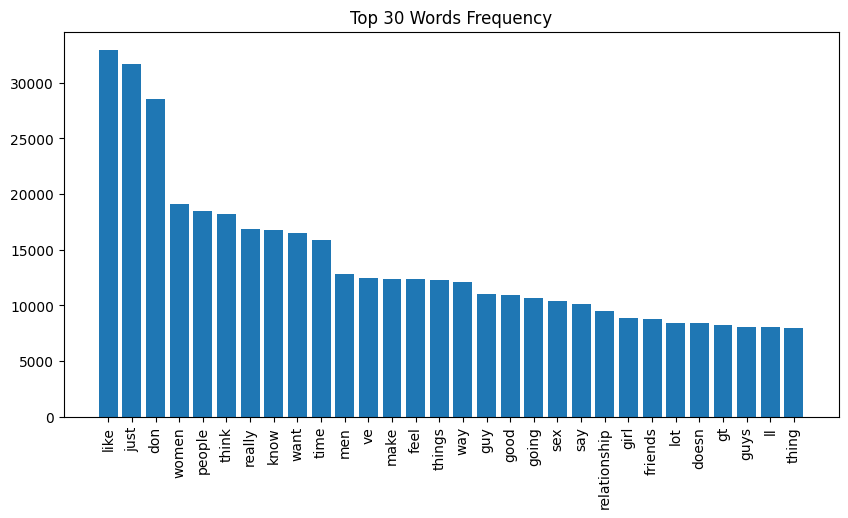

In [6]:
# word frequency histogram

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Vectorize the text data to count word occurrences
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(data['body'].values)

# Sum up the counts of each word in the vocabulary
word_counts = X_counts.toarray().sum(axis=0)
word_freq = [(word, word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# Plot the top 30 most frequent words
words = [wf[0] for wf in word_freq[:30]]
counts = [wf[1] for wf in word_freq[:30]]
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.title("Top 30 Words Frequency")
plt.show()

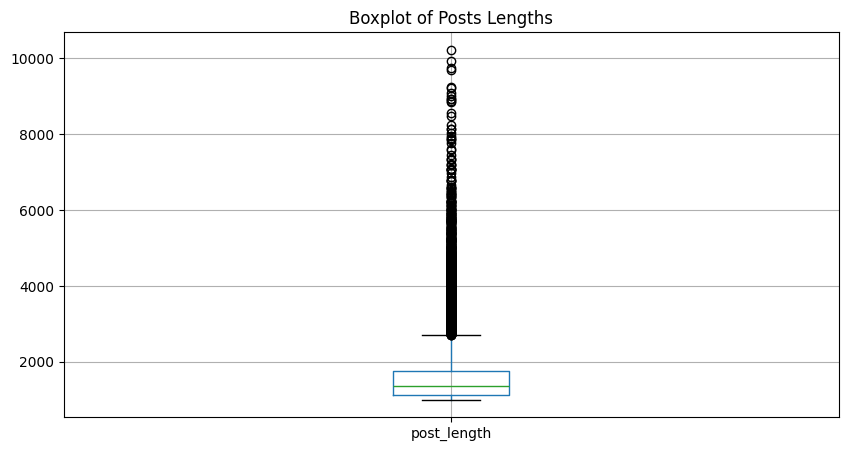

In [7]:
# Calculate the length of each document
df['post_length'] = df['text'].apply(len)

# Plot a boxplot of document lengths
plt.figure(figsize=(10, 5))
df.boxplot(column='post_length')
plt.title("Boxplot of Posts Lengths")
plt.show()

---

#### 2. **Basic Data Cleaning**
   - **Remove Non-Word Characters**: Strip all punctuation, special symbols, and other non-word characters.
   - **Remove Digits**: Delete any numeric characters.
   - **Convert to Lowercase**: Standardize text to lowercase for uniformity.
   - **Apply Stemming**: Reduce words to their root forms to help with generalization.

In [8]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Ensure consistent language detection
DetectorFactory.seed = 0

# Function to check if a text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False  # If detection fails, consider it non-English
    
print('Before filtering for English laguage: ', df.shape)

# Filter DataFrame to keep only English texts
df = df[df['text'].apply(is_english)]

print('After filtering for English laguage: ', df.shape)


Before filtering for English laguage:  (20000, 3)
After filtering for English laguage:  (19998, 3)


In [9]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the text data
df['clean_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marcin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---

#### 3. **TF-IDF Transformation**
   - **Transform Text**: Use **TF-IDF (Term Frequency-Inverse Document Frequency)** to convert the cleaned text data into numerical features. This will highlight terms that are important in specific comments but uncommon across all comments.
   - **Data for Clustering**: The resulting TF-IDF vectors will serve as input data for clustering.


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Transform the cleaned text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

In [11]:
X_tfidf.shape

(19998, 100)

---

#### 4. **Clustering**
   - **KMeans**
   - **DBSCAN**
   - **AgglomerativeClustering**

In [12]:
from sklearn.cluster import KMeans

# Apply K-Means with a predetermined number of clusters
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)

# Get the cluster assignments
labels_kmeans = kmeans.labels_
df['cluster_kmeans'] = labels_kmeans

In [13]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
dbscan.fit(X_tfidf)

# Get the cluster assignments
labels_dbscan = dbscan.labels_
df['cluster_dbscan'] = labels_dbscan

In [14]:
# from sklearn.cluster import AgglomerativeClustering

# # Apply Agglomerative Hierarchical Clustering
# agglo = AgglomerativeClustering(n_clusters=num_clusters, linkage='average')
# agglo.fit(X_tfidf.toarray())

# # Get the cluster assignments
# labels_agglo = agglo.labels_
# df['cluster_agglo'] = labels_agglo

In [14]:
from sklearn_extra.cluster import KMedoids

# Apply K-Medoids with a predetermined number of clusters
kmedoids = KMedoids(n_clusters=num_clusters, random_state=42, metric='cosine', max_iter=100)
kmedoids.fit(X_tfidf)

# Get the cluster assignments
labels_kmedoids = kmedoids.labels_
df['cluster_kmedoids'] = labels_kmedoids

---

#### 5. **Results evaluation**

In [16]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for each clustering algorithm
sil_score_kmeans = silhouette_score(X_tfidf, labels_kmeans)
# sil_score_dbscan = silhouette_score(X_tfidf, labels_dbscan)
# sil_score_agglo = silhouette_score(X_tfidf, labels_agglo)
sil_score_kmedoids = silhouette_score(X_tfidf, labels_kmedoids)

print(f'Silhouette Score for K-Means: {sil_score_kmeans}')
# print(f'Silhouette Score for DBSCAN: {sil_score_dbscan}')
# print(f'Silhouette Score for Agglomerative Clustering: {sil_score_agglo}')
print(f'Silhouette Score for KMedoids Clustering: {sil_score_kmedoids}')

Silhouette Score for K-Means: 0.032082669305209456
Silhouette Score for KMedoids Clustering: 0.008495697481140806


In [22]:
# create true_labels based on subreddit
df['true_labels'] = df['subreddit'].apply(lambda x: 1 if x == 'AskWomen' else 0)

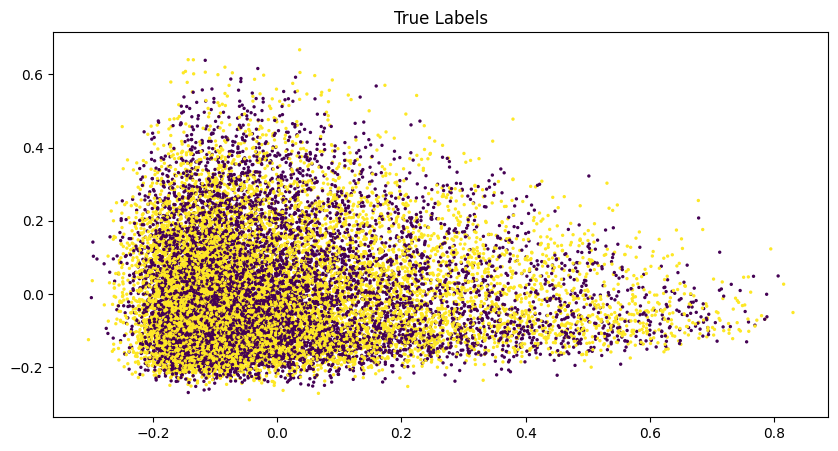

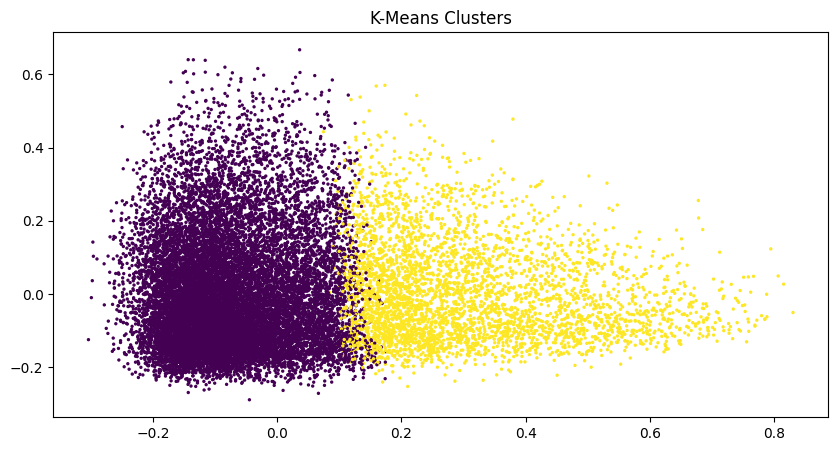

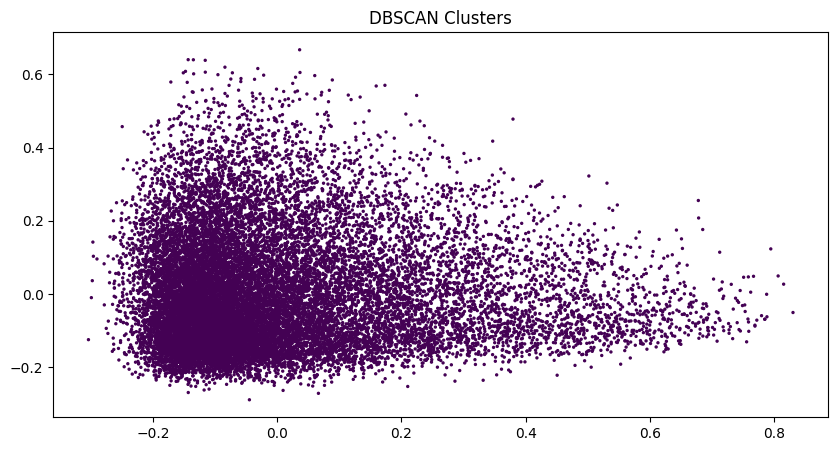

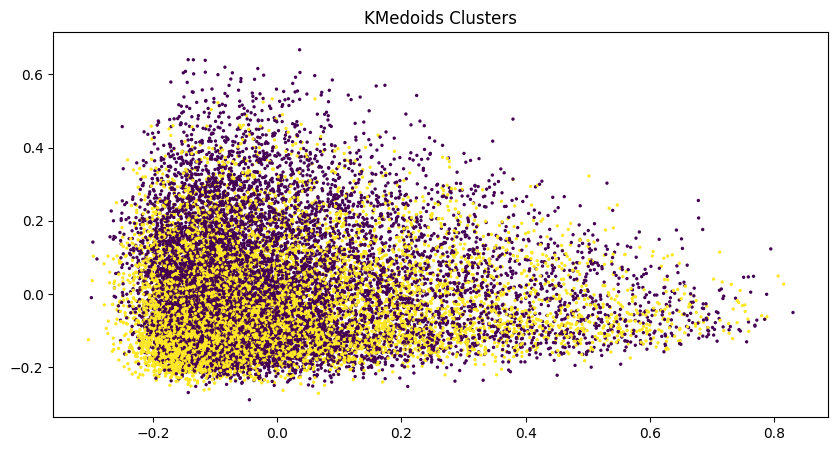

In [23]:
from sklearn.decomposition import PCA

# Function to plot clusters
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=2)
    plt.title(title)
    plt.show()

# Reduce dimensions to 2 for visualization
X_pca = PCA(n_components=2).fit_transform(X_tfidf.toarray())

# Visualize clusters
plot_clusters(X_pca, df['true_labels'], 'True Labels')
plot_clusters(X_pca, labels_kmeans, 'K-Means Clusters')
plot_clusters(X_pca, labels_dbscan, 'DBSCAN Clusters')
# plot_clusters(X_pca, labels_agglo, 'Agglomerative Clustering Clusters')
plot_clusters(X_pca, labels_kmedoids, 'KMedoids Clusters')

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

acc = accuracy_score(df['true_labels'], labels_kmedoids)
f1 = f1_score(df['true_labels'], labels_kmedoids)

print(f'Accuracy: {acc}')
print(f'F1 Score: {f1}')

Accuracy: 0.5059505950595059
F1 Score: 0.528580971466743


#### KMedoids

In [25]:
# getting some cluster and showing data from it
cluster = 0
cluster_data = df[kmedoids.labels_ == cluster]
for text in cluster_data['text'].values[:5]:
    print('\n############################################################\n')
    print(text)
    print('\n############################################################\n')


############################################################

I've never seen anyone get harassed or teased at a gym.  I had a guy tell me that keeping a fast pace and not taking rests was the best way to lift, but I just kinda smiled and nodded and went back to what I was doing.  I mean yeah, I'm skinnier than the average guy, but I've played sports my whole life and know what I'm doing. 

If you're being respectful I wouldn't ever give you flak, even jokingly.  Granted, if you're using a machine totally wrong, or lifting in a way that might hurt yourself I might give you a quick tip (just because I messed up my knee with bad squat form).  The way I see it, we're all there for a reason, and whether it's to gain or lose mass doesn't matter, and you should feel like you fit in.

But yeah, to answer the question, if someone made fun of someone else for being fat/skinny/ugly/sweaty/etc I'd either make it a point to say something to the asshole picking on em or go up, talk to em and give 

In [26]:
# getting some cluster and showing data from it
cluster = 1
cluster_data = df[kmedoids.labels_ == cluster]
for text in cluster_data['text'].values[:5]:
    print('\n############################################################\n')
    print(text)
    print('\n############################################################\n')


############################################################

I have been too all three for stags. scratch Toronto off your list.  if you guys got money to blow, go to cancun. cant beat all inclusive food and booze and spring break is wild in mexico. for a great parlor go to pleasure plaza in cancun.  be careful on the streets, lots of lady boys out there that set u up to be robbed. i got a tip on how to tell lady boys from real local chicks.  If its to good to be true. its to good to be true. if you see a group of hot looking mexican chicks and no mexican guys are hitting on them , its cause there lady boys.   Montreal is awesome to, the strippers and women in general are just so cool and not  stuck up at all. easy to meet women in montreal. clubs are awesome too and its pretty cheap. $100 a night and you can party like a VIP.  one friends is the money holder and collects 100 from everybody.  say you got 10 guys x 100$.=1000.  a 1 litre bottle cost $250 at most establishments and inc